# Support Vector Machine (a.k.a. Large Margin Classification)

## Boring stuff ... installing packages, importing things, fixing the world

In [1]:
!pip install plotly

In [2]:
# importing required modules
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import scipy.optimize
import sklearn.svm
import sklearn.datasets
import sklearn.model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

# some high DPI settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Error Analysis

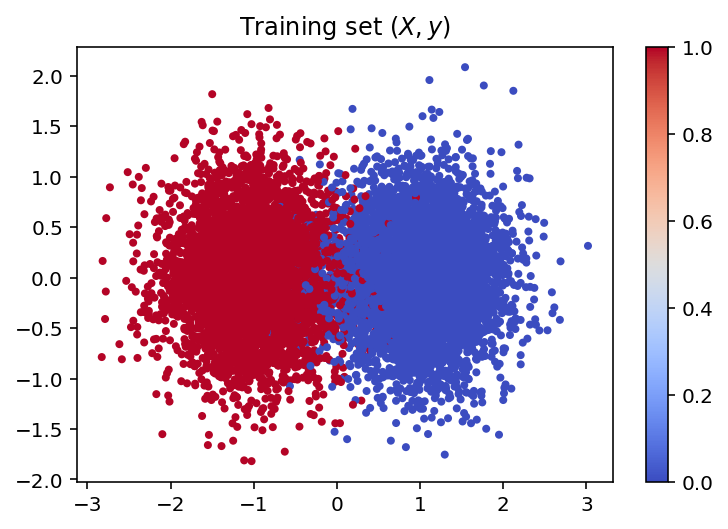

In [12]:
gaussian2d = lambda x, y, sigma, n: (np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))

m = 10000
half_m = int(m / 2)
sigma = 0.5

X = np.concatenate((
    np.array(gaussian2d(1, 0, sigma, half_m)).T,   # first half of the training set
    np.array(gaussian2d(-1, 0, sigma, half_m)).T   # second half of the training set
), axis=0)

y = np.concatenate((
    np.repeat(0, half_m), # setting results to 0
    np.repeat(1, half_m)  # setting results to 1
), axis=0)

permutation = np.eye(m)
np.random.shuffle(permutation)

# permutate X and y with P
X = np.matmul(permutation, X)
y = np.matmul(permutation, y)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, marker=".")
plt.colorbar()
plt.title("Training set $(X, y)$")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 2), (3000, 2), (7000,), (3000,))

## Regularization

$$J\big(\theta\big) = C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T f^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T f^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

Simplified:

$$ \min_{\theta} J\big(\theta\big) = \min_{\theta} C \cdot \theta \cdot x + \Vert\theta\Vert^2$$

* high $C$ $\rightarrow$ low $\theta$ (prone to underfitting)
* low $C$ $\rightarrow$ high $\theta$ (prone to overfitting)

In [24]:
regularization_classifier = sklearn.svm.SVC(kernel="rbf")
grid_classifier = sklearn.model_selection.GridSearchCV(
    estimator=regularization_classifier,
    param_grid={
        "C": np.logspace(start=-20, stop=6, num=10, base=10),
        "gamma": np.logspace(start=-1, stop=1, num=10)
    }, n_jobs=-1, verbose=2)
grid_classifier.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



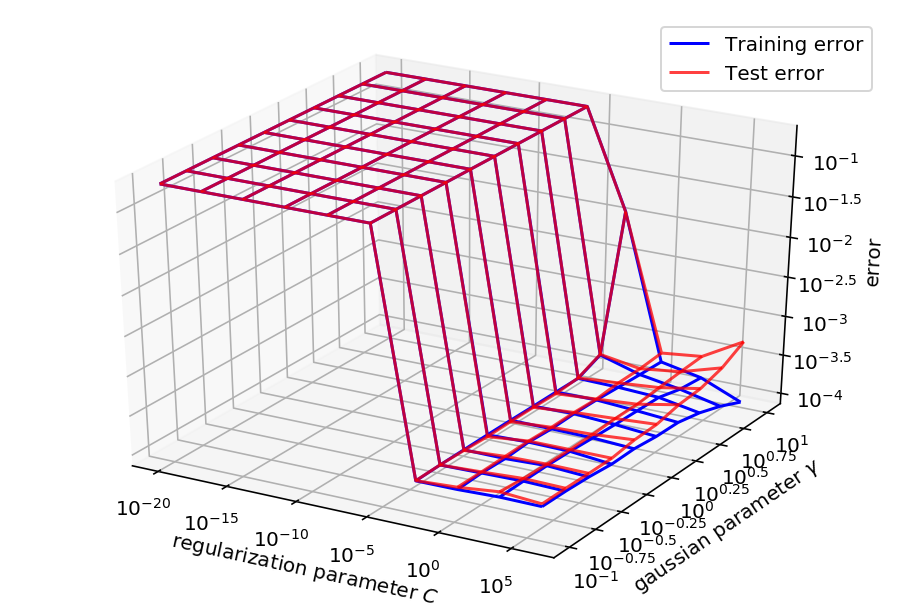

In [34]:
results = grid_classifier.cv_results_
data = pd.DataFrame(data=results["params"]).as_matrix()
cc = data[:, 0].reshape((10, 10))
gg = data[:, 1].reshape((10, 10))
train = pd.DataFrame(data=results["mean_train_score"]).as_matrix().reshape((10, 10))
test = pd.DataFrame(data=results["mean_test_score"]).as_matrix().reshape((10, 10))

fig = plt.figure()
ax = Axes3D(fig)

ax.plot_wireframe(np.log10(cc), np.log10(gg), np.log(1 - train), label="Training error", color="blue", alpha=1)
ax.plot_wireframe(np.log10(cc), np.log10(gg), np.log(1 - test), label="Test error", color="red", alpha=0.75)

def log_tick_formatter(val, pos=None):
    return "$10^{%g}$" % val

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel("regularization parameter $C$")
ax.set_ylabel("gaussian parameter $\gamma$")
ax.set_zlabel("error")
ax.legend()

plt.show()

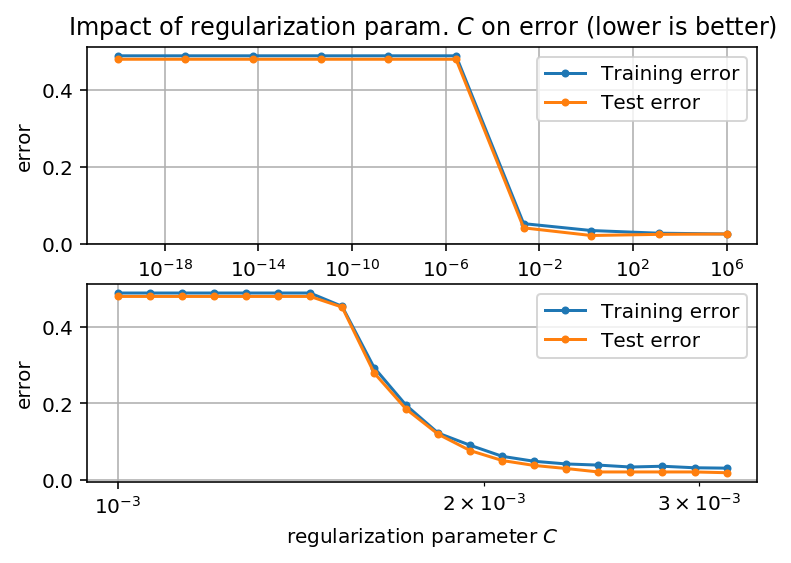

In [5]:
cc = np.logspace(start=-20, stop=6, num=10, base=10)
training_error = []
test_error = []
regularization_classifier = sklearn.svm.SVC(kernel="rbf", gamma=1)
for C in cc:
    regularization_classifier.set_params(C=C)
    regularization_classifier.fit(X_train[:1000], y_train[:1000])
    training_error.append(1 - regularization_classifier.score(X_train[:1000], y_train[:1000]))
    test_error.append(1 - regularization_classifier.score(X_test[:1000], y_test[:1000]))

plt.subplot(2, 1, 1)
plt.semilogx(cc, training_error, label="Training error", marker=".")
plt.semilogx(cc, test_error, label="Test error", marker=".")
plt.legend()
plt.title("Impact of regularization param. $C$ on error (lower is better)")
plt.ylabel("error")
plt.grid()

cc = np.logspace(start=-3, stop=-2.5, num=20, base=10)
training_error = []
test_error = []
for C in cc:
    regularization_classifier.set_params(C=C)
    regularization_classifier.fit(X_train[:1000], y_train[:1000])
    training_error.append(1 - regularization_classifier.score(X_train[:1000], y_train[:1000]))
    test_error.append(1 - regularization_classifier.score(X_test[:1000], y_test[:1000]))

plt.subplot(2, 1, 2)
plt.semilogx(cc, training_error, label="Training error", marker=".")
plt.semilogx(cc, test_error, label="Test error", marker=".")
plt.legend()
plt.xlabel("regularization parameter $C$")
plt.ylabel("error")
plt.grid()

plt.show()

Gaussian-hill, low $C$ reduces the hill, at some $C$ all points are in the same set, 50% error

## Learning curves

In [6]:
cc = np.logspace(start=-6, stop=5, num=20, base=10)
sizes = np.logspace(start=1, stop=3.845, num=20, base=10)
xx, yy = np.meshgrid(cc, sizes)
m_mesh = xx.ravel().shape[0]
X_mesh = np.c_[ xx.ravel(), yy.ravel() ]

size_classifier = sklearn.svm.SVC(kernel="rbf")

def error(C, size):
    size = int(size)
    size_classifier.set_params(C=C)
    size_classifier.fit(X_train[:size], y_train[:size])
    training_error = 1 - size_classifier.score(X_train[:size], y_train[:size])
    test_error = 1 - size_classifier.score(X_test, y_test)
    return (training_error, test_error)

Z = np.apply_along_axis(lambda x: error(x[0], x[1]), axis=1, arr=X_mesh)

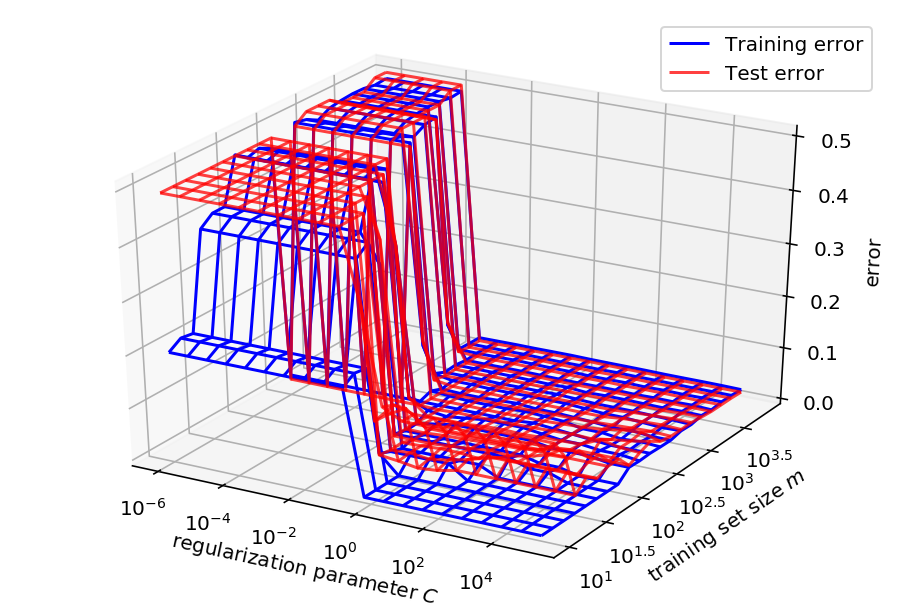

In [7]:
fig = plt.figure()
ax = Axes3D(fig)

ax.plot_wireframe(np.log10(xx), np.log10(yy), Z[:, 0].reshape(xx.shape), label="Training error", color="blue", alpha=1)
ax.plot_wireframe(np.log10(xx), np.log10(yy), Z[:, 1].reshape(xx.shape), label="Test error", color="red", alpha=0.75)

def log_tick_formatter(val, pos=None):
    return "$10^{%g}$" % val

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel("regularization parameter $C$")
ax.set_ylabel("training set size $m$")
ax.set_zlabel("error")
ax.legend()

plt.show()

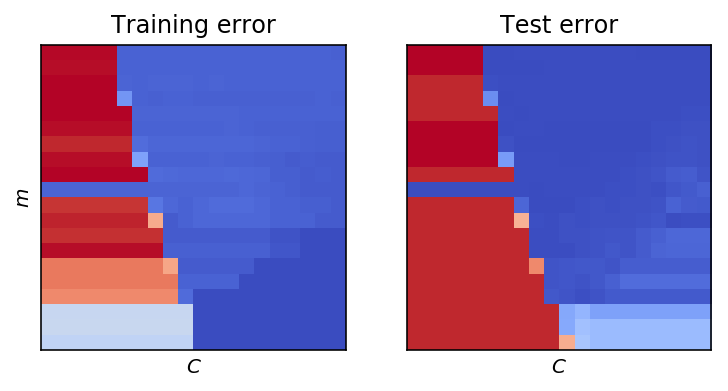

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(np.flip(Z[:, 0].reshape(xx.shape), 0), cmap=plt.cm.coolwarm)
plt.title("Training error")
plt.xlabel("$C$")
plt.ylabel("$m$")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(np.flip(Z[:, 1].reshape(xx.shape), 0), cmap=plt.cm.coolwarm)
plt.title("Test error")
plt.xlabel("$C$")
plt.xticks([], [])
plt.yticks([], [])

plt.show()

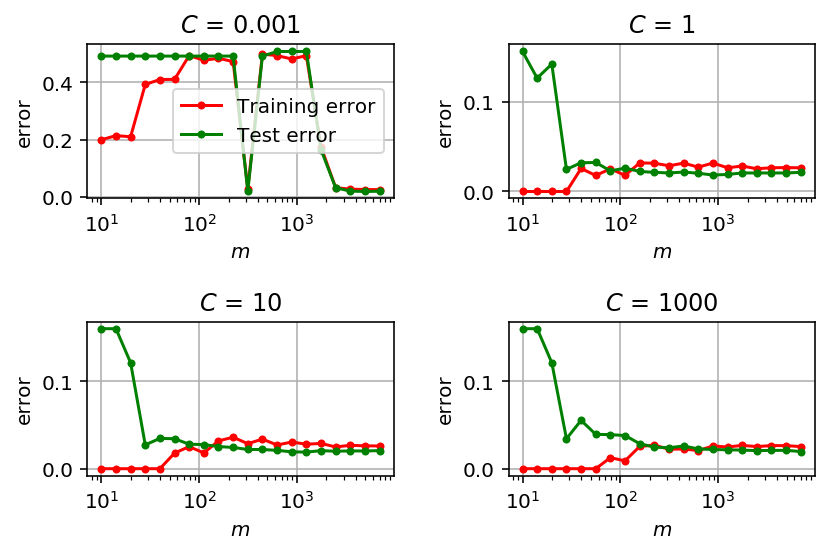

In [9]:
sizes = np.logspace(start=1, stop=3.845, num=20, base=10)
cc = [ 0.001, 1, 10, 1000 ]

training_error = []
test_error = []

for C in cc:
    for size in sizes:
        size = int(size)
        size_classifier.set_params(C=C)
        size_classifier.fit(X_train[:size], y_train[:size])
        training_error.append(1 - size_classifier.score(X_train[:size], y_train[:size]))
        test_error.append(1 - size_classifier.score(X_test, y_test))

for i, C in enumerate(cc):
    plt.subplot(2, 2, i + 1)
    plt.semilogx(sizes,
        training_error[(len(sizes) * i):(len(sizes) * (i + 1))],
        label="Training error", marker=".", color="r")
    plt.semilogx(sizes,
        test_error[(len(sizes) * i):(len(sizes) * (i + 1))],
        label="Test error", marker=".", color="g")
    if i == 0:
        plt.legend()
    plt.grid()
    plt.ylabel("error")
    plt.xlabel("$m$")
    plt.title("$C$ = %g" % C)

plt.tight_layout()
plt.show()

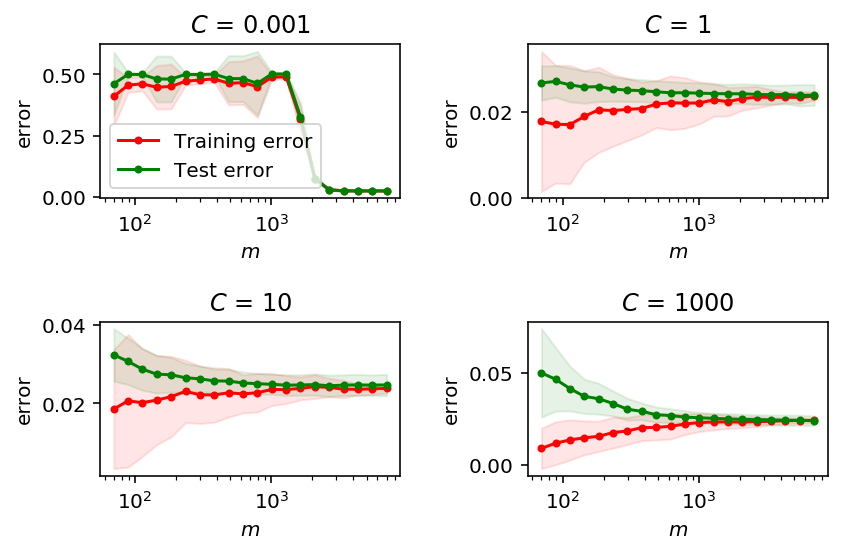

In [36]:
def plot_learning_curve(estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"""
    train_sizes, train_scores, test_scores = sklearn.model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores = 1 - train_scores
    test_scores = 1 - test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.semilogx(train_sizes, train_scores_mean, ".-", color="r",
             label="Training error")
    plt.semilogx(train_sizes, test_scores_mean, ".-", color="g",
             label="Test error")

cross_validation_generator = sklearn.model_selection.ShuffleSplit(n_splits=20, test_size=0.3)

cc = [ 0.001, 1, 10, 1000 ]

for i, C in enumerate(cc):
    plt.subplot(2, 2, i + 1)
    size_classifier.set_params(C=C)
    plot_learning_curve(size_classifier, X, y, cv=cross_validation_generator, n_jobs=-1,
        train_sizes=np.logspace(start=-2, stop=0, num=20, base=10))
    if i == 0:
        plt.legend()
    plt.grid()
    plt.ylabel("error")
    plt.xlabel("$m$")
    plt.title("$C$ = %g" % C)

plt.tight_layout()
plt.show()

# Conclusion

* Do not implement algorithms, use libraries
* Random helps you everywhere
* Good training data
* Error analysis

### Fork this notebook on GitHub!

<img src="qr-code-to-github-repo.svg" />

<center>https://github.com/NIPE-SYSTEMS/support-vector-machine</center>